In [1]:
# ================================
# 1. Import Dependencies
# ================================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

In [2]:
# ================================
# 2. Preprocessing Words
# ================================
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    stemmer = StemmerFactory().create_stemmer()
    stopwords = set(StopWordRemoverFactory().get_stop_words())
    text = text.lower()
    words = text.split()
    cleaned = [w for w in words if w not in stopwords]
    return stemmer.stem(" ".join(cleaned))

🧹 [Step 3] Preprocessing with tqdm...


100%|██████████| 3000/3000 [11:46<00:00,  4.24it/s]


📊 Jumlah data per label:
label
mudah     1000
sedang    1000
sulit     1000
Name: count, dtype: int64


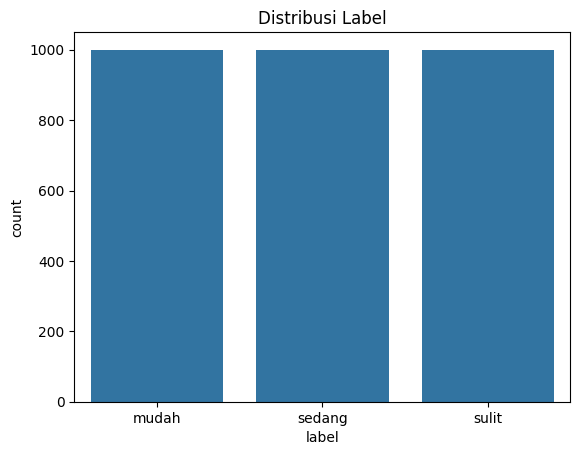

In [3]:
# ================================
# 3. Load Data & Visualisasi
# ================================
data_path = os.path.join("..", "model", "kalimat_difficulty_100.xlsx")
df = pd.read_excel(data_path).dropna()

print("🧹 [Step 3] Preprocessing with tqdm...")
tqdm.pandas()
df["clean"] = df["kalimat"].progress_apply(preprocess_text)

print("📊 Jumlah data per label:")
print(df["label"].value_counts())
sns.countplot(data=df, x="label")
plt.title("Distribusi Label")
plt.show()

In [4]:
# ================================
# 4. TF-IDF Scaling
# ================================
print("⚙️ [Step 4] Vectorizing text...")
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
X = vectorizer.fit_transform(df["clean"]).toarray()

⚙️ [Step 4] Vectorizing text...


In [5]:
# ================================
# 5. Encode & Split Data
# ================================
print("✂️ [Step 5] Splitting data...")
encoder = LabelEncoder()
y = encoder.fit_transform(df["label"])
y_cat = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, stratify=y, random_state=42
)

✂️ [Step 5] Splitting data...


In [6]:
# ================================
# 6. Build Deep Learning Model
# ================================
model = Sequential([
    Dense(128, activation='relu', input_shape=(X.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

c:\Users\maraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
# ================================
# 7. Train Model
# ================================
model_path = os.path.join("..", "model", "difficulty_model_dl.h5")
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/20
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4613 - loss: 1.0742

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.4653 - loss: 1.0728 - val_accuracy: 0.8354 - val_loss: 0.8559
Epoch 2/20
50/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8489 - loss: 0.7050

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8511 - loss: 0.6777 - val_accuracy: 0.9021 - val_loss: 0.3157
Epoch 3/20
56/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9371 - loss: 0.2211

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9363 - loss: 0.2209 - val_accuracy: 0.8896 - val_loss: 0.2493
Epoch 4/20
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9459 - loss: 0.1558

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9462 - loss: 0.1551 - val_accuracy: 0.8979 - val_loss: 0.2418
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9677 - loss: 0.1007 - val_accuracy: 0.8938 - val_loss: 0.2503
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9754 - loss: 0.0775 - val_accuracy: 0.8917 - val_loss: 0.2642
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9797 - loss: 0.0690 - val_accuracy: 0.8875 - val_loss: 0.2878


📈 [Step 8] Plotting training performance...


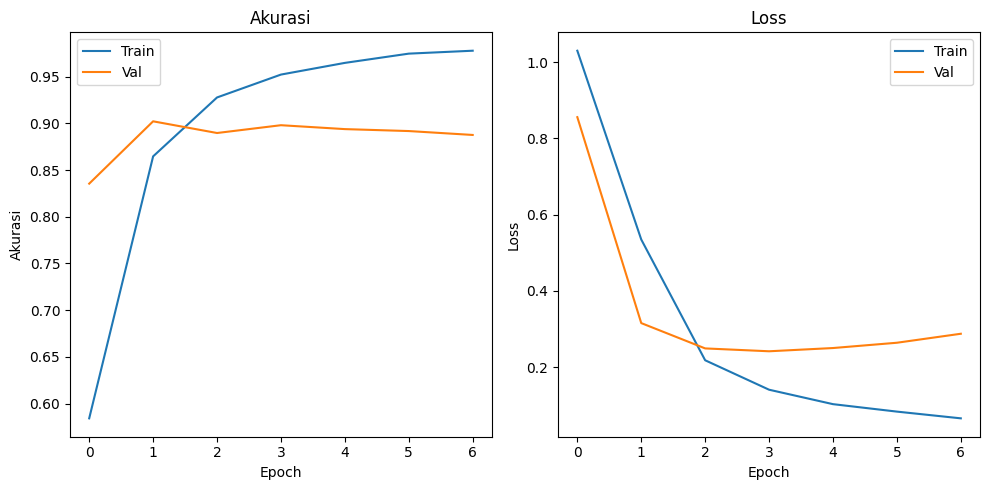

In [8]:
# ================================
# 8. Plot Performance
# ================================
print("📈 [Step 8] Plotting training performance...")
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("Akurasi")
plt.xlabel("Epoch")
plt.ylabel("Akurasi")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()


🧪 [Step 9] Evaluating model...

✅ Test Accuracy: 0.9183
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

📄 Classification Report:
              precision    recall  f1-score   support

       mudah       0.95      0.93      0.94       200
      sedang       0.88      0.88      0.88       200
       sulit       0.93      0.94      0.94       200

    accuracy                           0.92       600
   macro avg       0.92      0.92      0.92       600
weighted avg       0.92      0.92      0.92       600



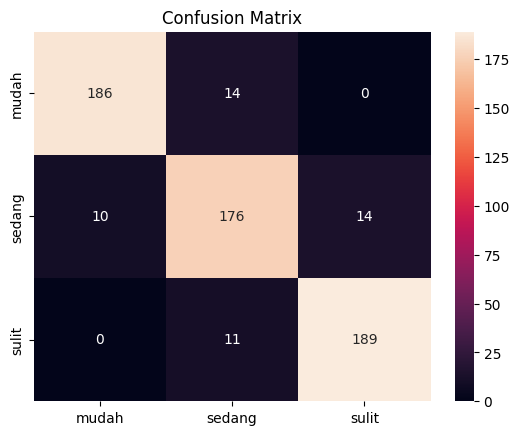

In [9]:
# ================================
# 9. Evaluate Model
# ================================
print("🧪 [Step 9] Evaluating model...")
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Accuracy: {acc:.4f}")

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\n📄 Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=encoder.classes_))

sns.heatmap(confusion_matrix(y_true, y_pred_classes), annot=True, fmt='d',
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title("Confusion Matrix")
plt.show()

In [10]:
# ================================
# 10. Save Model & Vectorizer
# ================================
print("💾 [Step 10] Saving model & artifacts...")
vec_path = os.path.join("..", "model", "tfidf_vectorizer.pkl")
enc_path = os.path.join("..", "model", "label_encoder.pkl")

joblib.dump(vectorizer, vec_path)
joblib.dump(encoder, enc_path)

print(f"\n🎉 Model saved to {model_path}")

💾 [Step 10] Saving model & artifacts...

🎉 Model saved to ..\model\difficulty_model_dl.h5
